In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import json, pandas as pd, glob, tqdm
import gzip

def label(line, label, idx=-1, dx=0, **kwargs):
    if isinstance(line, list): line = line[0]
    x, y = line.get_data()
    plt.text(
        x[idx]+dx,
        y[idx],
        label,
        **kwargs, color=line.get_color())
    

plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# plt.rcParams['font.family'] = 'Noto sans'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.directory'] = '.'
plt.rcParams['font.size'] = 16
import jax
import jax.numpy as jnp


def spatial_to_delay(r, from_=None):
    if from_ is not None:
        d = jax.vmap(lambda ri: jnp.sqrt(1e-2+((from_ - ri)**2).sum(axis=1)))(r)
        # d.shape is here (r.shape[0], from_.shape[0])
        d = d.flatten()
        return d
    else:
        d = jax.vmap(lambda ri: jnp.sqrt(1e-2+((r - ri)**2).sum(axis=1)))(r)
        d = diagonal_const(d, 1000000)
        d = d.flatten()
        return d
    
    

def diagonal_const(arr, c):
    n = arr.shape[0]
    return arr * (1 - jnp.eye(n)) + jnp.eye(n) * c

In [3]:
!pwd

tables = {}

for f in tqdm.tqdm(glob.glob('saved/*/log.jsons*')):
    args, hparams = {}, {}
    handle = gzip.open(f, 'rt') if f.endswith('.gz') else open(f)
    try:
        with handle as fh:
            for l in fh:
                j = json.loads(l)
                t = j.pop('table')
                if t == 'args': args = j
                elif t == 'hyperparams': hparams = j
                elif t in {'epoch', 'sparse_epoch'}:
                    j.update(args)
                    j.update(hparams)
                    tables.setdefault(t, []).append(j)
    except Exception as ex:
        print()
        print(repr(ex))
        print(f)
        print()

dfs = {t: pd.DataFrame(v) for t, v in tables.items()}
epoch = dfs['epoch']


epoch['plotdim'] = epoch.apply(lambda x:
                               6 if x.netspec == 'inf' else x['ndim'], 1)

final = epoch[(epoch.i == 29) & (epoch.dt == 0.5)]
final = final[final.tgtfreq == 10]

/home/llandsmeer/repos/llandsmeer/spatial_delays


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 406/406 [00:06<00:00, 66.15it/s]


# SHD

0
∞
2
3


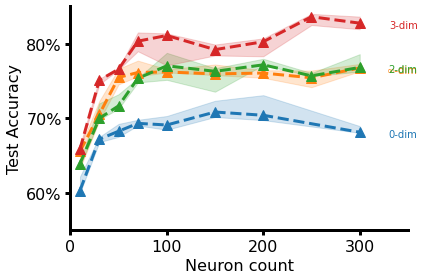

In [134]:
final = epoch[(epoch.i == 29) & (epoch.dt == 0.5) & (epoch['sparse'] == 1.)]
final = final[final.tgtfreq == 10]

take = [
    '0', 'inf', '2', '3'
    ]

finalnormal = final# [(final.net.isin(take)) & (True != final['sparse']) & (final.tgtfreq==10) & (final.population_freq != True) & (line != True)]
finalnormal = final# [(final.net.isin(take)) & (True != final['sparse']) & (final.tgtfreq==10) & (final.population_freq != True) & (line != True)]

finalnormal

ERR = False



plt.xlabel('Neuron count')
if ERR:
    plt.ylim([0, 50])
    plt.ylabel('Test Error')
else:
    plt.ylabel('Test Accuracy')
    plt.ylim([55, 85])
    plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
plt.xticks([0, 100, 200, 300])
plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    if len(sub.index) == 0:
        continue
        print(net)
    not_done = (sub.groupby('nhidden')['id'].count() != 5).sum()
    # if not_done: print('WARN NOT DONE', net, not_done, sub.groupby('nhidden')['id'].count())
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    if ERR: y = 100 - y
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    line,  = plt.plot(sub.index, y, '^--', label=net, color=color)
    plt.fill_between(sub.index, low.t1p, high.t1p, color=line.get_color(), alpha=0.2)
    net = net.replace('inf', '∞')
    plt.text(
        sub.index.values[-1]+60,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='right',
        color=line.get_color()
    )
    print(net)
    plt.tight_layout()
    plt.savefig(f'img2/{net}-dim.svg')
    plt.savefig(f'img2/{net}-dim.png', dpi=300)

#plt.legend(title='Network Dimensions', ncol=2)
plt.show()


0
            median       low      high
nhidden                               
10       60.329861 -0.318283  1.866322
30       67.201965 -0.390625  0.303818
50       68.272568 -0.752312  0.983803
70       69.328705 -0.289352  0.477425
100      69.111687 -0.636566  1.200813
150      70.847801 -0.665512  1.504631
200      70.413773 -0.651039  2.690971
300      68.142365 -0.079575  0.824650

inf
            median       low      high
nhidden                               
10       65.581596 -2.271408  0.549774
30       70.529518 -0.853592  1.765045
50       75.477432 -0.925926  1.171875
70       76.142937 -0.506363  1.591438
100      76.215279 -0.057869  0.361687
150      75.954865 -0.159149  1.258675
200      76.070602 -0.636574  0.376152
250      75.434029 -1.258682  0.969330
300      76.750580 -0.441261  0.542534

2
            median       low      high
nhidden                               
10       63.917828 -0.347221  0.217014
30       69.994217 -0.173615  2.010994
50       71.67

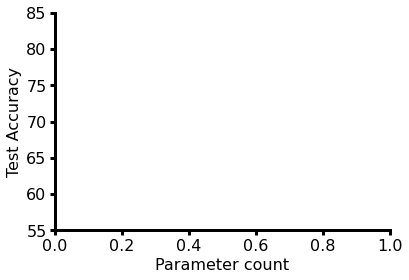

In [144]:
take = [
    '0', 'inf', '2', '3'
    ]


#finalnormal = final[final.net.isin(take)]
finalnormal = final#[(final.net.isin(take))  & (final['sparse']!= final['sparse']) &
#(final.tgtfreq==10) & (final.population_freq != True) & (final.line != True) &
#(final.adex != final.adex)] #& (final.tag == 'default')]


finalnormal


plt.xlabel('Parameter count')
plt.ylabel('Test Accuracy')
plt.ylim([55, 85])
# plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
# plt.xticks([0, 100, 200, 300])
# plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    if len(sub.index) == 0:
        continue
        print(net)
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25).t1p
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75).t1p
    median = sub[['nhidden', 't1p']].groupby('nhidden').median().t1p
    
    print()
    print(net)
    x = pd.DataFrame(dict(median=median, low=low-median , high=high-median))
    print(x)


0
            median        low       high
nhidden                                 
10       60.329861  60.011578  62.196182
30       67.201965  66.811340  67.505783
50       68.272568  67.520256  69.256371
70       69.328705  69.039352  69.806129
100      69.111687  68.475121  70.312500
150      70.847801  70.182289  72.352432
200      70.413773  69.762733  73.104744
300      68.142365  68.062790  68.967014

inf
            median        low       high
nhidden                                 
10       65.581596  63.310188  66.131371
30       70.529518  69.675926  72.294563
50       75.477432  74.551506  76.649307
70       76.142937  75.636574  77.734375
100      76.215279  76.157410  76.576965
150      75.954865  75.795715  77.213539
200      76.070602  75.434029  76.446754
250      75.434029  74.175346  76.403358
300      76.750580  76.309319  77.293114

2
            median        low       high
nhidden                                 
10       63.917828  63.570606  64.134842
30   

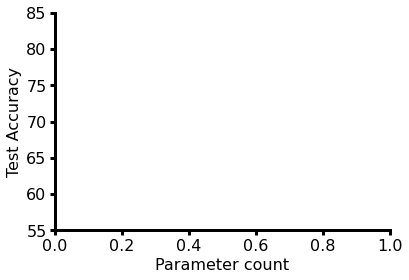

0
∞
2
3


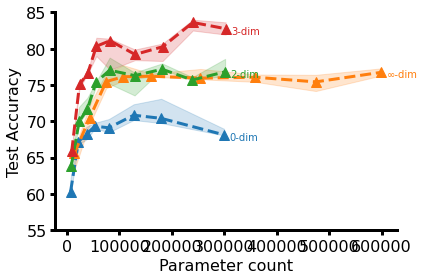

In [12]:
take = [
    '0', 'inf', '2', '3'
    ]


#finalnormal = final[final.net.isin(take)]
finalnormal = final#[(final.net.isin(take))  & (final['sparse']!= final['sparse']) &
#(final.tgtfreq==10) & (final.population_freq != True) & (final.line != True) &
#(final.adex != final.adex)] #& (final.tag == 'default')]


finalnormal


plt.xlabel('Parameter count')
plt.ylabel('Test Accuracy')
plt.ylim([55, 85])
# plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
# plt.xticks([0, 100, 200, 300])
# plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    if len(sub.index) == 0:
        continue
        print(net)
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    neurons = sub.index.values
    if net == '0':
        params = neurons * (neurons - 1) + 700 * neurons
    elif net == 'inf':
        params = 2 * neurons * (neurons - 1) + 2 * 700 * neurons
    else:
        params = 700 * neurons + int(net)*700 + neurons * (neurons - 1) + neurons * int(net)
    line,  = plt.plot(params, y, '^--', label=net, color=color)
    plt.fill_between(params, low.t1p, high.t1p, color=line.get_color(), alpha=0.2)
    net = net.replace('inf', '∞')
    plt.text(
        params[-1]+10000,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='left',
        color=line.get_color()
    )
    print(net)
    
plt.tight_layout()
plt.savefig(f'img2/nofill-params-dim.svg')
plt.savefig(f'img2/nofill-params-dim.png', dpi=300)

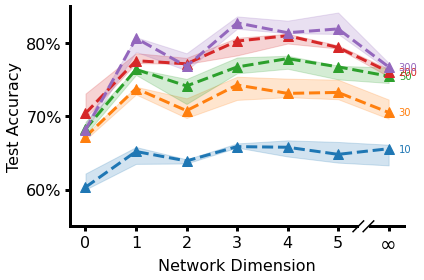

In [13]:
import matplotlib.transforms as mtrans

take = [
    '0', '1', '2', '3', '4', '5', 'inf'
    ]
ax = plt.gca()

finalnormal = final#[(final.net.isin(take))  & (final['sparse']!= final['sparse']) &
#(final.tgtfreq==10) & (final.population_freq != True) & (final.line != True) &
#(final.adex != final.adex)] #& (final.tag == 'default')]

take_nh = [ 10, 30, 50, 200, 300]

plt.ylabel('Test Accuracy')
plt.ylim([55, 85])
plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

ticks = [0, 1, 2, 3, 4, 5, 6]
labels = [0, 1, 2, 3, 4, 5, '∞']
ax.set_xticks(ticks)
text_labels = ax.set_xticklabels(labels)

text_labels[-1].set_fontsize(20)

for nh, sub in finalnormal.groupby('nhidden'):
    if take_nh and nh not in take_nh: continue
    if len(sub.index) == 0:
        continue
        print(net)
    sub = sub.sort_values('plotdim')
    low = sub[['plotdim', 't1p']].groupby('plotdim').quantile(0.25)
    high = sub[['plotdim', 't1p']].groupby('plotdim').quantile(0.75)
    #std = sub[['plotdim', 't1p']].groupby('plotdim').std()
    sub = sub[['plotdim', 't1p']].groupby('plotdim').median()
    #low = sub-std
    #high = sub+std
    line,  = plt.plot(sub.index, sub.t1p, '^--')
    plt.fill_between(sub.index, low.t1p, high.t1p, color=line.get_color(), alpha=0.2)
    plt.text(
        sub.index.values[-1]+0.2,
        sub.t1p.values[-1],
        f'{nh}',
        va='center',
        ha='left',
        color = line.get_color()
    )

plt.gcf().canvas.draw()
x_positions = [5.4, 5.6]
y_data = ax.get_ylim()[0]
L_px = 15.0
half = L_px / 2.0
d = half / np.sqrt(2.0)
to_display = ax.transData.transform
to_data = ax.transData.inverted().transform
to_display = ax.transData.transform
to_data = ax.transData.inverted().transform
ax.plot([min(x_positions)+0.03, -0.03+max(x_positions)], [y_data, y_data], color='w', linewidth=3, clip_on=False, zorder=10)
for x0 in x_positions:
    x_disp, y_disp = to_display((x0, y_data))
    p1_disp = (x_disp - d, y_disp - d)
    p2_disp = (x_disp + d, y_disp + d)
    p1_data = to_data(p1_disp)
    p2_data = to_data(p2_disp)
    ax.plot([p1_data[0], p2_data[0]], [p1_data[1], p2_data[1]],
            color='k', linewidth=1.5, clip_on=False, zorder=100)
plt.xlabel('Network Dimension')
plt.tight_layout()
plt.savefig('img2/netw.svg')
plt.savefig('img2/netw.png')
plt.show()

In [14]:
epoch

,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,adex_dt,vplot,pos,iadapt0,shard,ninput,noutput,netspec,ndim,plotdim
0,d10d6b8c-1784-4d34-ba45-38f208d3d706,0,40.133102,71.513313,32.061298,66.015625,4,30,32,None,...,0.1,False,False,0.1,False,700,20,4,4.0,4.0
1,d10d6b8c-1784-4d34-ba45-38f208d3d706,1,48.379627,79.354744,61.207932,89.723557,4,30,32,None,...,0.1,False,False,0.1,False,700,20,4,4.0,4.0
2,d10d6b8c-1784-4d34-ba45-38f208d3d706,2,57.754631,87.413193,67.728363,90.249397,4,30,32,None,...,0.1,False,False,0.1,False,700,20,4,4.0,4.0
3,d10d6b8c-1784-4d34-ba45-38f208d3d706,3,55.381947,83.579285,72.896637,94.050484,4,30,32,None,...,0.1,False,False,0.1,False,700,20,4,4.0,4.0
4,d10d6b8c-1784-4d34-ba45-38f208d3d706,4,61.140049,88.556129,74.218750,93.960335,4,30,32,None,...,0.1,False,False,0.1,False,700,20,4,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11020,0554f741-ccd1-416d-9b82-32ce37fc4aa7,25,71.180557,91.796875,95.808296,99.609375,2e0.20,30,32,None,...,0.1,False,False,0.1,False,700,20,2e0.20,2.0,2.0
11021,0554f741-ccd1-416d-9b82-32ce37fc4aa7,26,71.585648,91.623268,96.093750,100.000000,2e0.20,30,32,None,...,0.1,False,False,0.1,False,700,20,2e0.20,2.0,2.0
11022,0554f741-ccd1-416d-9b82-32ce37fc4aa7,27,70.659721,91.015625,95.462738,99.804688,2e0.20,30,32,None,...,0.1,False,False,0.1,False,700,20,2e0.20,2.0,2.0
11023,0554f741-ccd1-416d-9b82-32ce37fc4aa7,28,71.527779,89.641205,95.567909,100.000000,2e0.20,30,32,None,...,0.1,False,False,0.1,False,700,20,2e0.20,2.0,2.0


# T-SpSNN

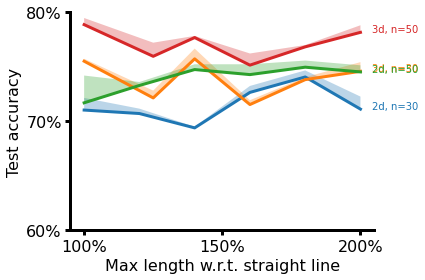

In [15]:
finaleps = (epoch[(epoch.i == 29) & (epoch.net.apply(lambda x: 'e' in x))]).copy()

finaleps['eps'] = finaleps['netspec'].str.split('e').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]
finaleps = finaleps.drop('netspec', axis='columns').drop('net', axis='columns').drop('id', axis='columns')
# print(finaleps.groupby(['nhidden', 'plotdim', 'eps']).count())
low = finaleps.groupby(['nhidden', 'plotdim', 'eps']).quantile(0.5).reset_index().drop('seed', axis='columns')
high = finaleps.groupby(['nhidden', 'plotdim', 'eps']).quantile(0.75).reset_index().drop('seed', axis='columns')
finaleps = finaleps.groupby(['nhidden', 'plotdim', 'eps']).median().reset_index().drop('seed', axis='columns')
#finaleps = finaleps[finaleps.nhidden == 10].groupby('net').median().sort_values('netspec')

# 10, 30, 50
#for n in [10, 30, 50]:
for n in [30, 50]:
    x =finaleps[finaleps.nhidden == n]
    l =low[low.nhidden == n]
    h =high[high.nhidden == n]
    for d in [2, 3]:
        label(plt.plot(
            100+100*x[x.plotdim==d].eps,
            x[x.plotdim==d].t1p,
            '-'),
            f'{d}d, n={n}', dx=4)
        plt.fill_between(
            100+100*x[x.plotdim==d].eps.values,
            l[l.plotdim==d].t1p.values,
            h[h.plotdim==d].t1p.values, alpha=0.3, zorder=-100)

        
ml = np.array([100, 150, 200])
plt.xticks(ml, [f'{x}%' for x in ml])

#plt.legend()
plt.ylabel('Test accuracy')
plt.xlabel('Max length w.r.t. straight line')

plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

plt.tight_layout()
#plt.savefig('img/eps.svg')
#plt.savefig('img/eps.png')

In [16]:
finaleps

,nhidden,plotdim,eps,t1p,t3p,t1p_train,t3p_train,ndim
0,30,2.0,0.00,71.035881,90.885414,97.175484,99.804688,2.0
1,30,2.0,0.20,70.717590,91.883682,97.265625,99.609375,2.0
2,30,2.0,0.40,69.401039,88.628471,96.679688,99.609375,2.0
3,30,2.0,0.60,72.656250,91.449654,97.656250,99.804688,2.0
4,30,2.0,0.80,74.074074,92.997688,97.611176,99.804688,2.0
5,30,2.0,1.00,71.122688,90.827553,96.679688,99.609375,2.0
6,30,3.0,0.00,75.520836,92.288773,96.784859,99.804688,3.0
7,30,3.0,0.25,72.149879,91.608803,97.130409,99.804688,3.0
8,30,3.0,0.40,75.737846,92.809608,97.415863,100.000000,3.0
9,30,3.0,0.60,71.542244,91.276039,97.851562,99.804688,3.0


,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,vplot,pos,iadapt0,shard,ninput,noutput,netspec,ndim,plotdim,eps
179,29162c0e-31fc-4ace-8936-f884d59cde45,29,77.170143,94.155090,97.265625,100.000000,3e0.80,50,32,None,...,False,False,0.1,False,700,20,3e0.80,3.0,3.0,0.80
507,fcf04a86-5bb2-41d2-b985-62c6efed093a,29,69.401039,87.991898,97.070312,99.609375,2e0.40,30,32,None,...,False,False,0.1,False,700,20,2e0.40,2.0,2.0,0.40
597,9a3f8b99-15e4-4ed0-a03a-426e11130276,29,80.092590,93.460648,97.656250,99.804688,3e0.00,50,32,None,...,False,False,0.1,False,700,20,3e0.00,3.0,3.0,0.00
657,a86a1c00-7938-4d1b-a6c8-e183f6acbcaf,29,71.817131,91.435188,98.828125,100.000000,2e0.60,50,32,None,...,False,False,0.1,False,700,20,2e0.60,2.0,2.0,0.60
717,ac4e15f5-1362-46f8-b302-3d28cc9899cc,29,75.969330,92.983215,96.484375,100.000000,3e0.00,30,32,None,...,False,False,0.1,False,700,20,3e0.00,3.0,3.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10149,c4b9f270-4c3d-4974-8a4f-483cc4ca419f,29,71.035881,91.608803,97.265625,99.804688,2e0.00,30,32,None,...,False,False,0.1,False,700,20,2e0.00,2.0,2.0,0.00
10578,b1c9c85c-2040-4662-8730-b5cce799a240,29,71.990746,91.507523,97.130409,99.804688,3e0.25,30,32,None,...,False,False,0.1,False,700,20,3e0.25,3.0,3.0,0.25
10608,244d8299-ac21-4d53-8ce8-9818e29d26fc,29,69.270836,87.717018,97.025238,99.609375,2e0.60,30,32,None,...,False,False,0.1,False,700,20,2e0.60,2.0,2.0,0.60
10758,f4104814-0db1-4b0a-bb0a-ee91a4887b87,29,74.291092,94.227432,99.414062,100.000000,2e0.60,50,32,None,...,False,False,0.1,False,700,20,2e0.60,2.0,2.0,0.60


0.0
0.2
0.4
0.6
0.8
1.0


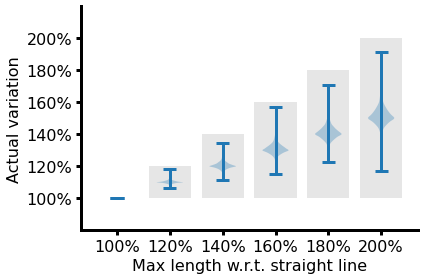

In [17]:
finaleps
finaleps = (epoch[(epoch.i == 29) & (epoch.net.apply(lambda x: 'e' in x))]).copy()
finaleps['eps'] = finaleps['netspec'].str.split('e').str[1].astype(float)

display(finaleps)

finaleps = finaleps.loc[:, finaleps.nunique() > 1]

dd = dict()
for _idx, row in finaleps.iterrows():
    fns = glob.glob(f'saved/*{row.id}*/epoch_*029.npz')
    if not fns:
        continue
    if row.plotdim != 2:
        continue
    fn, = fns
    d = np.load(fn)
    ieps = 100 + 100 * row.eps * (0.5 + 0.5 * np.tanh(d['ierr']))
    reps = 100 + 100 * row.eps * (0.5 + 0.5 * np.tanh(d['rerr']))
    if row.eps not in dd:
        dd[row.eps] = []
    dd[row.eps].extend(reps)
    
plt.bar(
    np.arange(1, len(dd)+1),
    100*np.array(sorted(dd.keys())),
    bottom=100,
    color='0.9')

plt.violinplot(
    [dd[k] for k in sorted(dd.keys())]
);

for i, k in enumerate(sorted(dd.keys()), 1):
    print(k)

plt.xticks(np.arange(1, len(dd)+1), [f'{100+x*100:.0f}%' for x in sorted(dd.keys())])
# plt.yticks([100, 150, 200], ['100', '150%', '200%'])
plt.yticks([100+x*100 for x in sorted(dd.keys())],
           [f'{100+x*100:.0f}%' for x in sorted(dd.keys())])

#plt.xlabel('Epsilon')
plt.ylabel('Actual variation')
plt.xlabel('Max length w.r.t. straight line')

plt.ylim(80, 220)


#plt.

#trace = [
#    dict(np.load(x))
#    for x in 
#    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
#        'saved/*3e1*/epoch_*.npz'
#    ) if not 'read' in x)
##]
plt.tight_layout()
plt.savefig('img2/epsuse.svg')
plt.savefig('img2/epsuse.png')

# Sparse

In [68]:
epoch[(epoch.i==1) &
      (epoch.net.apply(lambda x: 'e' not in x)) &
      (epoch.nhidden == 300) &
      (epoch['sparse'] == 0.1)
     ]


,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,adex_dt,vplot,pos,iadapt0,shard,ninput,noutput,netspec,ndim,plotdim
1379,6e94d4c7-2d8e-418c-af7c-e86d81513422,1,60.170715,82.638893,59.645432,86.117790,3,300,32,None,...,0.1,False,False,0.1,False,700,20,3,3.0,3.0
1559,b7e1d496-2534-4e55-b55c-85c8f3679470,1,51.822918,77.589699,62.184494,85.036057,inf,300,32,None,...,0.1,False,False,0.1,False,700,20,inf,inf,6.0
1735,70861a0d-7c9e-42c8-8c27-b6b3622f9af5,1,56.423611,83.579285,65.054085,89.858772,inf,300,32,None,...,0.1,False,False,0.1,False,700,20,inf,inf,6.0
2746,baa34f55-d362-414c-bd37-7be36ee620e5,1,47.482639,82.320602,53.410458,82.256607,inf,300,32,None,...,0.1,False,False,0.1,False,700,20,inf,inf,6.0
7548,5c24df4a-304c-4685-96b5-a1702831e14c,1,53.530094,83.709496,59.540264,89.182693,inf,300,32,None,...,0.1,False,False,0.1,False,700,20,inf,inf,6.0
8386,ac59d54a-c534-4375-9ab0-7ffb9aadde2c,1,50.969330,79.224533,55.543869,80.799278,3,300,32,None,...,0.1,False,False,0.1,False,700,20,3,3.0,3.0
8716,c9290c71-82f5-4a4f-9cf0-1865e52e2d98,1,61.385994,89.901619,61.598557,86.598557,3,300,32,None,...,0.1,False,False,0.1,False,700,20,3,3.0,3.0


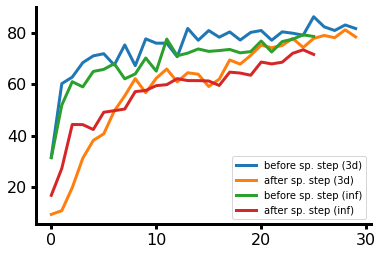

In [102]:
sparse_epoch = dfs['sparse_epoch']
x = sparse_epoch[sparse_epoch.id == '6e94d4c7-2d8e-418c-af7c-e86d81513422']
plt.plot(x.i, x.t1p, label='before sp. step (3d)')
plt.plot(x.i, x.t1p_sp, label='after sp. step (3d)')




x = sparse_epoch[sparse_epoch.id == 'b7e1d496-2534-4e55-b55c-85c8f3679470']
plt.plot(x.i, x.t1p, label='before sp. step (inf)')
plt.plot(x.i, x.t1p_sp, label='after sp. step (inf)')
plt.legend()
      
plt.savefig('img2/progress.png')
plt.savefig('img2/progress.svg')

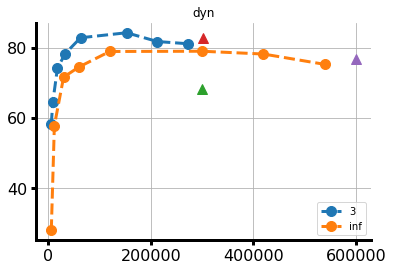

In [103]:
for net in ['3', 'inf']:
    df = sparse_epoch[
          (sparse_epoch.net.apply(lambda x: 'e' not in x)) &
          (sparse_epoch.nhidden == 300) &
          (sparse_epoch.i == 29) &
          (sparse_epoch.netspec == net)
         ]
    x = df.groupby('sparse').t1p_sp.median()
    sp = x.index
    neurons = 300
    if net == '0':
        params = (sp * (neurons * (neurons - 1))).astype(int) + (sp * (700 * neurons)).astype(int)
    elif net == 'inf':
        params = (sp * (2 * neurons * (neurons - 1))).astype(int) + (sp * (2 * 700 * neurons)).astype(int)
    else:
        params = (sp * 700 * neurons).astype(int) + int(net)*700 + (sp * neurons * (neurons - 1)).astype(int) + neurons * int(net)
    plt.plot(params, x.values, 'o--',label=net)

final = epoch[
    (epoch.i == 29) &
    (epoch.dt == 0.5) &
    (epoch['sparse'] == 1.) &
    (final.tgtfreq == 10) &
    (final.netspec.apply(lambda x: 'e' not in x)) &
    (final.nhidden == 300)
    ]
    
plt.legend()
plt.grid()
    
plt.title('dyn')
plt.savefig('img2/params_spcmp.png')
plt.savefig('img2/params_spcmp.svg')

dense = final['t1p net'.split()].groupby('net').median()
for net, t1p in zip(dense.index, dense.values):
    if net not in '0 3 inf'.split():
        continue
    sp = np.array(1.)
    if net == '0':
        params = (sp * (neurons * (neurons - 1))).astype(int) + (sp * (700 * neurons)).astype(int)
    elif net == 'inf':
        params = (sp * (2 * neurons * (neurons - 1))).astype(int) + (sp * (2 * 700 * neurons)).astype(int)
    else:
        params = (sp * 700 * neurons).astype(int) + int(net)*700 + (sp * neurons * (neurons - 1)).astype(int) + neurons * int(net)
    plt.plot(params, t1p, '^',label=net)

sparse
0.01    58.318867
0.02    64.626740
0.05    74.204285
0.10    78.327553
0.20    82.870369
0.50    84.302658
0.70    81.799774
0.90    81.163193
Name: t1p_sp, dtype: float64
sparse
0.01    27.994791
0.02    57.812500
0.05    71.657990
0.10    74.551506
0.20    78.964119
0.50    79.036461
0.70    78.240746
0.90    75.289352
Name: t1p_sp, dtype: float64


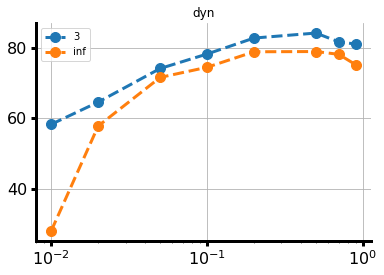

In [104]:

for net in ['3', 'inf']:
    df = sparse_epoch[
          (sparse_epoch.net.apply(lambda x: 'e' not in x)) &
          (sparse_epoch.nhidden == 300) &
          # (sparse_epoch['sparse'] == 0.1) &
          (sparse_epoch.i == 29) &
          (sparse_epoch.netspec == net)
         ]
    x = df.groupby('sparse').t1p_sp.median()
    plt.plot(x.index, x.values, 'o--',label=net)
    print(x)

    
plt.xscale('log')
plt.legend()
plt.grid()
    
plt.title('dyn')
plt.savefig('img2/spcmp.png')
plt.savefig('img2/spcmp.svg')

## YY

In [107]:
from io import StringIO

df = pd.read_csv(StringIO('''
net	nneuron	accuracy
3	25	97.1875
4	25	93.046875
3	60	98.32031
2	30	95.56641
2	60	98.02734
2	30	97.20703
3	60	98.828125
4	25	88.73047
2	20	92.48047
3	25	94.84375
1	60	97.38281
3	20	95.859375
3	25	97.1875
4	30	97.30469
2	30	97.36328
1	10	80.29297
4	30	93.41797
3	60	98.14453
3	25	93.046875
3	20	93.32031
1	60	97.734375
2	20	93.65234
2	15	84.00391
1	60	98.47656
3	25	93.57422
3	25	96.66016
3	60	98.53516
2	15	87.94922
2	15	75.46875
2	60	97.63672
2	60	97.28516
1	10	78.59375
3	60	98.08594
3	25	96.81641
3	25	93.86719
1	60	98.28125
2	15	84.82422
3	25	96.5625
2	25	96.5625
4	30	91.67969
3	60	98.08594
2	30	95.82031
2	20	93.18359
2	15	90.68359
2	15	88.515625
2	30	96.60156
2	60	98.4375
2	10	86.44531
3	60	98.18359
4	30	95.95703
2	25	96.97266
3	25	97.63672
1	30	95.56641
3	10	80.01953
3	45	98.18359
4	45	97.53906
2	25	95.546875
2	45	98.828125
2	25	96.19141
2	10	79.31641
2	45	98.18359
2	25	97.28516
4	20	95.21484
3	45	98.26172
3	10	87.28516
1	45	98.33984
3	60	97.40234
2	30	93.90625
3	10	88.76953
1	30	95.13672
4	20	88.80859
3	30	97.44141
1	15	83.24219
1	60	97.34375
1	10	75.25391
3	45	98.14453
1	15	89.49219
1	30	96.36719
3	10	81.07422
2	60	97.46094
3	10	83.86719
1	25	82.71484
2	10	85.01953
4	15	79.33594
1	20	95.17578
1	25	93.76953
3	45	98.61328
2	25	93.359375
3	30	95.09766
2	25	97.55859
3	30	97.94922
1	10	76.05469
3	45	98.02734
1	25	97.28516
1	20	92.109375
3	45	97.16797
4	15	83.046875
1	25	93.80859
3	10	91.89453
1	30	96.85547
3	10	90.83984
1	10	81.38672
1	25	96.67969
4	10	70.52734
3	45	98.53516
4	20	95.82031
2	25	95.80078
4	20	96.5625
3	45	97.98828
1	20	92.1875
3	10	82.07031
1	30	97.55859
3	15	92.61719
3	15	93.32031
2	60	98.57422
4	60	97.40234
1	20	84.51172
2	60	97.59766
2	30	95.87891
4	10	70.68359
4	60	97.14844
2	10	75.87891
3	30	96.69922
3	30	97.75391
2	10	79.88281
2	60	98.14453
1	20	93.00781
4	45	97.63672
2	60	97.34375
2	15	87.08984
3	15	94.35547
2	25	92.8125
3	15	80.95703
3	15	92.20703
4	60	96.26953
3	45	98.08594
4	15	87.890625
2	20	89.23828
4	10	84.609375
3	30	96.75781
2	15	88.06641
3	30	97.53906
4	10	84.94141
4	15	92.30469
3	45	97.734375
4	60	96.25
3	10	88.88672
3	15	85.546875
3	15	88.73047
4	25	92.48047
2	10	85.95703
2	45	98.37891
3	30	97.96875
2	10	77.98828
2	10	82.578125
2	45	97.890625
4	25	89.765625
3	10	84.140625
1	45	97.5
3	15	86.30859
3	15	92.44141
2	15	90.76172
4	60	97.40234
4	10	81.484375
2	45	98.53516
3	30	97.44141
2	10	87.51953
2	10	82.05078
3	30	96.44531
2	45	98.125
1	15	89.31641
1	15	77.83203
3	15	91.328125
2	45	97.83203
2	20	93.84766
3	20	94.453125
3	60	97.98828
2	20	91.19141
2	30	97.65625
2	20	91.99219
3	20	96.19141
1	45	97.63672
2	15	88.65234
2	45	97.94922
2	45	97.75391
3	20	95.09766
3	20	89.72656
2	45	97.890625
1	45	97.83203
3	20	97.20703
2	30	96.953125
2	30	96.46484
3	20	94.453125
1	45	97.67578
3	20	96.62109
3	60	97.92969
2	25	97.59766
2	60	97.98828
2	20	91.58203
2	20	81.05469
3	20	94.90234
2	20	88.75
1	15	81.77734
0	10	74.375
0	25	79.375
0	60	92.578125
0	60	93.203125
0	30	79.51172
inf	60	96.50391
0	25	85.05859
0	10	74.21875
inf	45	97.48047
inf	25	95.97656
0	20	75.37109
0	10	75.13672
0	20	76.44531
inf	15	90.48828
inf	45	97.14844
inf	25	97.75391
inf	30	96.52344
0	25	77.421875
0	20	81.05469
0	10	75.60547
0	10	74.21875
0	15	73.69141
inf	30	98.86719
inf	25	96.46484
0	15	78.86719
0	20	78.984375
inf	60	97.34375
0	60	95.82031
0	20	78.94531
0	15	75.01953
inf	25	95.27344
inf	20	93.88672
inf	60	96.66016
inf	60	97.01172
inf	20	94.94141
inf	20	93.18359
inf	60	97.20703
inf	20	92.87109
inf	60	96.50391
0	45	88.71094
inf	20	96.21094
inf	20	95.78125
0	45	92.38281
inf	60	96.60156
0	45	93.02734
inf	20	94.43359
inf	20	94.86328
0	45	90.17578
inf	10	88.65234
inf	60	97.1875
inf	10	87.51953
0	45	93.28125
inf	20	93.86719
inf	10	86.44531
inf	60	97.20703
inf	10	80.42969
inf	10	84.58984
inf	10	82.1875
inf	10	88.37891
inf	20	97.67578
inf	60	97.92969
inf	10	82.30469
inf	10	89.64844
inf	10	81.015625
inf	45	97.578125
inf	30	97.08984
0	30	86.42578
0	30	81.71875
inf	30	98.125
inf	25	96.50391
inf	45	97.79297
inf	30	97.79297
inf	45	98.86719
0	15	74.53125
0	30	85.13672
0	15	76.30859
inf	45	97.20703
inf	30	97.79297
inf	15	92.5
inf	30	95.50781
inf	45	97.63672
0	25	79.43359
0	30	86.44531
0	60	92.34375
0	60	93.71094
0	25	78.45703
inf	45	97.63672
inf	30	96.71875
inf	15	91.19141
inf	45	97.98828
inf	15	92.85156
inf	30	96.953125
inf	30	97.44141
inf	15	94.16016
inf	45	96.69922
'''.strip()), sep='\t',dtype={'net': 'string'})



neurons = [10, 15, 20, 25, 30, 45, 60]
x = np.array([None] * len(df))
for n, nparam in zip(neurons, [70, 105, 140, 175, 210, 315, 420]):
    x[(df.net == '0') & (df.nneuron == n)] = nparam
    
    
for n, nparam in zip(neurons, [140, 210, 280, 350, 420, 630, 840]):
    x[(df.net == 'inf') & (df.nneuron == n)] = nparam
for n, nparam in zip(neurons, [87, 127, 167, 207, 247, 367, 487]):
    x[(df.net == '1') & (df.nneuron == n)] = nparam
for n, nparam in zip(neurons, [104, 149, 194, 239, 284, 419, 554]):
    x[(df.net == '2') & (df.nneuron == n)] = nparam
for n, nparam in zip(neurons, [121, 171, 221, 271, 321, 471, 621]):
    x[(df.net == '3') & (df.nneuron == n)] = nparam
for n, nparam in zip(neurons, [138, 193, 248, 303, 358, 523, 688]):
    x[(df.net == '4') & (df.nneuron == n)] = nparam

    
df['nparams'] = x
df

,net,nneuron,accuracy,nparams
0,3,25,97.187500,271
1,4,25,93.046875,303
2,3,60,98.320310,621
3,2,30,95.566410,284
4,2,60,98.027340,554
...,...,...,...,...
293,inf,15,92.851560,210
294,inf,30,96.953125,420
295,inf,30,97.441410,420
296,inf,15,94.160160,210


93.203125
97.734375
98.03711
98.115235
97.6074225


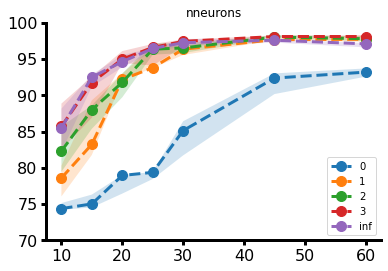

In [133]:
for net in '0 1 2 3 inf'.split():
    g = df[df.net == net].drop('net', axis='columns').groupby('nneuron')
    median = g.median()
    low = g.accuracy.quantile(0.25)
    high = g.accuracy.quantile(0.75)
    plt.plot(median.index, median.accuracy, 'o--', label=net)
    plt.fill_between(median.index, low, high, alpha=0.2)
    print(median.accuracy.max())
plt.legend()
plt.title('nneurons')

plt.ylim(70, 100)

plt.savefig('img2/yy1.png')
plt.savefig('img2/yy1.svg')

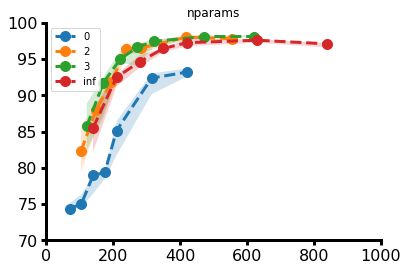

In [126]:
for net in '0 2 3 inf'.split():
    g = df[df.net == net].drop('net', axis='columns').groupby('nparams')
    median = g.median()
    low = g.accuracy.quantile(0.25)
    high = g.accuracy.quantile(0.75)
    plt.plot(median.index, median.accuracy, 'o--', label=net)
    plt.fill_between(median.index, low, high, alpha=0.2)
plt.legend()
plt.title('nparams')
plt.xlim(0, 1000)


plt.ylim(70, 100)
plt.savefig('img2/yy2.png')
plt.savefig('img2/yy2.svg')

(70.0, 100.0)

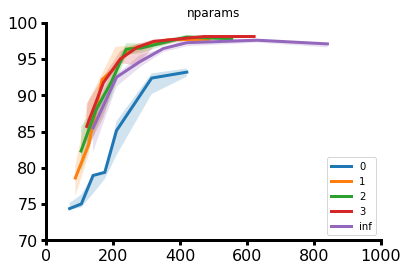

In [111]:

for net in '0 1 2 3 inf'.split():
    g = df[df.net == net].drop('net', axis='columns').groupby('nparams')
    median = g.median()
    low = g.accuracy.quantile(0.25)
    high = g.accuracy.quantile(0.75)
    plt.plot(median.index, median.accuracy, label=net)
    plt.fill_between(median.index, low, high, alpha=0.2)
plt.legend()
plt.title('nparams')
plt.xlim(0, 1000)
plt.ylim(70, 100)

[10, 15, 20, 25, 30, 45, 60]


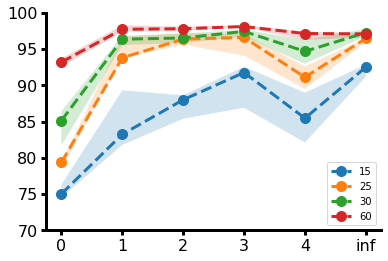

In [127]:
#for n in sorted((df.nneuron.unique())):
print( sorted((df.nneuron.unique())) )
for n in [15, 25, 30, 60]:
    g = df[df.nneuron == n].drop('nneuron', axis='columns').groupby('net')
    median = g.median()
    low = g.accuracy.quantile(0.25)
    high = g.accuracy.quantile(0.75)
    y = median.accuracy
    # y = 100 - y
    plt.plot(median.index, y, 'o--', label=n)
    plt.fill_between(median.index, low, high, alpha=0.2)
plt.legend()
# plt.yscale('log')
plt.ylim(70, 100)

plt.savefig('img2/yy3.png')
plt.savefig('img2/yy3.svg')